
#### Problem 1
**a)** The most common objective for SVM when we have slack variables (soft margin SVM) is:
$$J(\theta,\xi) = \frac{1}{2}\|\theta\|^2 + C\| \xi \|_p^p \quad (p \geq 1)$$

   subject to the constraints,
$$ y_i(\theta^Tx_i+\theta_0) \geq 1 - \xi_i,\quad \xi_i \geq 0,\quad \forall i = 1,\cdots,n$$
  which quantifies our intuition that $\xi_i$ must be small.

* This makes SVM training a convex optimization problem since the objective is convex function and the constraint is a linear inequality which defines a convex set.

* Usually, p=1 (L1 Soft Margin SVM/Lasso for regression) or p=2 (L2 Soft Margin SVM/Ridge for regression). For p=2, the primal is strictly convex and thus the solution is unique.

**b)** The **support vectors** are defined as those vectors that identify the separating hyperplane of maximum margin. This means that $(\theta,\theta_0)$ can be written as a linear combination of exactly those vectors. They are those vectors that have non-zero Lagrange multipliers.

**c)** Prepare data, downsample and split MNIST into train/validation set

In [ ]:
!pip install scikit-learn scikit-image

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
ds = fetch_openml('mnist_784', as_frame = False)
x, x_test , y, y_test = train_test_split(ds.data, ds.target, test_size=0.2, random_state=42)

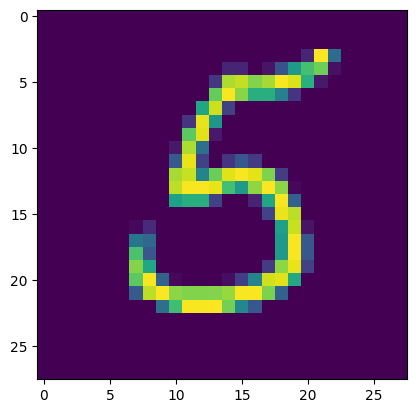

In [ ]:
# import matplotlib.pyplot as plt
a = x[0].reshape ((28 ,28))
plt.imshow (a)

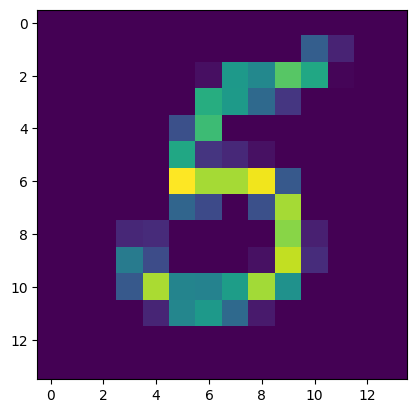

In [ ]:
# code for downsampling
import cv2
b = np.array(a, dtype='uint8')
b=cv2.resize(b,(14,14))
plt.imshow(b)

In [ ]:
# downsampling function
def downsampling(x):
  a = x.reshape((28 ,28))
  a = np.array(a, dtype='uint8') # OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:3970: error: (-215:Assertion failed) func != 0 in function 'resize'
  b = cv2.resize(a, (14 ,14))
  return b.flatten() #b.ravel()


In [ ]:
# import numpy as np

x_sub = []
y_sub = []

for i in range(10):
    all_idx_of_i = np.where(x == i)[0]

    random_idx = np.random.choice(all_idx_of_i, 1000, replace=False)

    x_sub.extend([downsampling(image) for image in x[random_idx]])
    y_sub.extend(y[random_idx])


x_sub = np.array(x_sub)
y_sub = np.array(y_sub)

x_train, x_val, y_train, y_val = train_test_split(x_sub, y_sub, test_size=0.2, random_state=42)



### d) Create and an Fit SVM Classifier
* The sklearn.svm.SVC documentation (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
* **C** : penalty parameter of C the error term (default=1.0) (It can also be viewed as the upper limit for the Lagrange coeffcients if we form the dual problem).
* **gamma** : Kernel coefficient for 'rbf','poly','sigmoid' (default 'auto' = $\frac{1}{n_{features}}$. For 'rbf' for example, it is inversely proportional to the variance.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [ ]:
# from sklearn import svm
classifier = svm.SVC(C=1.0, kernel ='rbf', gamma ='auto')
# C is the regularization parameter and gamma is the kernel coefficient. Default values: C=1.0 and gamma='scale'

# fit SVM using training datasets
classifier.fit(x_train, y_train)

SVC(gamma='auto')

In [ ]:
# do prediction to the validation set
y_val_pred = classifier.predict(x_val)

# report the validation error
val_error = 1 - accuracy_score(y_val, y_val_pred)

print("Validation Error:"); val_error

Validation Error:


0.05800000000000005

In [ ]:
# ratio: # of support samples/the total number of training samples
ratio = len(classifier.support_)/len(x_train);  print("Ratio:");ratio

Ratio:


0.4405

In [ ]:
# Run the classifier on x_test, y_test and report the classification error
x_test = [downsampling(a) for a in x_test]
x_test = scaler.fit_transform(x_test)

x_test = np.array(x_test)

y_test_pred = classifier.predict(x_test)

classfi_error = 1 - accuracy_score(y_test, y_test_pred)
print("Classification error"); classfi_error

Classification error


0.06085714285714283

In [ ]:
# report the 10-class confusion matrix

#from sklearn.metrics import confusion_matrix
#import seaborn as sns

# Mix of label input types (string and number
y_test = y_test.astype(int)
y_test_pred = y_test_pred.astype(int)

confusion = confusion_matrix(y_test, y_test_pred)

print(confusion)


[[1301    1   12    1    0    7   12    2    6    1]
 [   0 1558   15    7    1    7    0    3    7    2]
 [   5    6 1302   11   10    5   11    3   24    3]
 [   5    5   42 1297    2   28    3   23   19    9]
 [   4    2   24    2 1207    7    6    7    3   33]
 [   4    1    7   22    2 1206   18    2   10    1]
 [   7    0   19    0    6   11 1350    0    3    0]
 [   2    5   30    4   13    3    0 1392    7   47]
 [   4   10   19   17    6   33    5    6 1250    7]
 [   8    5   27   19   22    3    0   39   12 1285]]


**e)** The link for libsvm explains the shrinking parameter and its use in improving kernel cache hit rates by temporarily removing dual variables unlikely to be selected in the SMO optimization algorithm. The algorithm, based on the paper Fan et al., 2005, (http://www.jmlr.org/papers/volume6/fan05a/fan05a.pdf) is a SMO-type method solving the dual quadratic program by updating a subset of Lagrange multipliers. It decomposes the problem into smaller subproblems, improving memory usage but resulting in slow convergence. The paper suggests selecting parameters to update by identifying violating pairs using a second-order objective.

**f)** For binary classifiers, common multiclass extensions are one-vs-one, where multiple classifiers "vote" to classify a point, and one-vs-all, where classifiers are trained to differentiate one class against all others. A new point is classified based on the decision function that yields the highest value. Although the one-vs-one approach is mentioned in the documentation, the default for SVC() is now one-vs-all, which is preferred for faster training, though it may be inconsistent



### Problem 1.g Grid search


In [ ]:
# Use the sklearn.model_selection.GridSearchCV function to pick a better value than the default C.
# Try 5. Show accuracies.

from sklearn.model_selection import GridSearchCV

classifier = svm.SVC(kernel='rbf', gamma='auto')

param_C = {'C': [0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(estimator=classifier, param_grid=param_C)

grid_search.fit(x_train, y_train)

GridSearchCV(estimator=SVC(gamma='auto'),
             param_grid={'C': [0.1, 1, 10, 100, 1000]})

In [ ]:
results = grid_search.cv_results_

for mean, param in zip(results['mean_test_score'], results['params']):
    print(f"Parameters: {param}, Accuracy: {mean:.4f}")

# Best hyperparameter found
print(f"\nBest C value: {grid_search.best_params_['C']}, with the highest accuracy: {grid_search.best_score_:.4f}")


Parameters: {'C': 0.1}, Accuracy: 0.8776
Parameters: {'C': 1}, Accuracy: 0.9424
Parameters: {'C': 10}, Accuracy: 0.9525
Parameters: {'C': 100}, Accuracy: 0.9523
Parameters: {'C': 1000}, Accuracy: 0.9523

Best C value: 10, with the highest accuracy: 0.9525


#### Problem 1.h

In [ ]:
x_sub_small = []
y_sub_small = []

for i in range(10):
    idx_of_i = np.where(x == i)[0]

    # 100 samples/class for train, and 100 samples/class for val, 200 in total
    random_idx_s = np.random.choice(idx_of_i, 200, replace=False)

    x_sub_small.extend([downsampling(image) for image in x[random_idx_s]])
    y_sub_small.extend(y[random_idx_s])


x_sub_small = np.array(x_sub_small)
y_sub_small = np.array(y_sub_small)

x_train_small, x_val_small, y_train_small, y_val_small = train_test_split(x_sub_small, y_sub_small, test_size=0.5, random_state=42)

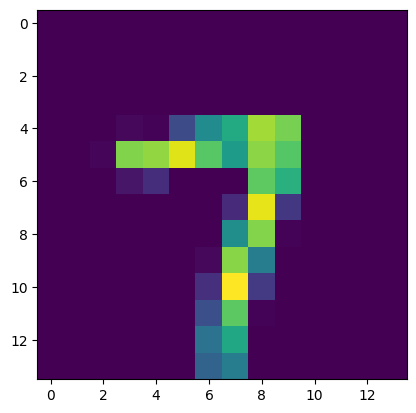

In [ ]:
b = x_train_small[55].reshape((14 ,14))
plt.imshow(b)

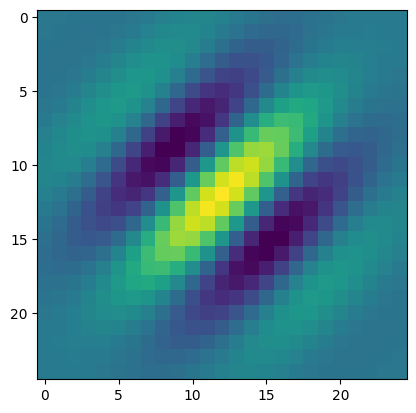

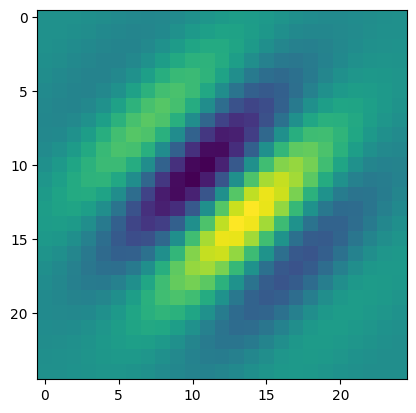

In [ ]:
from skimage.filters import gabor_kernel, gabor
import numpy as np
freq, theta, bandwidth = 0.1, np.pi/4, 1
gk = gabor_kernel (frequency = freq, theta = theta, bandwidth = bandwidth)
plt.figure (1); plt.clf (); plt.imshow (gk.real)
plt.figure (2); plt.clf (); plt.imshow (gk.imag)

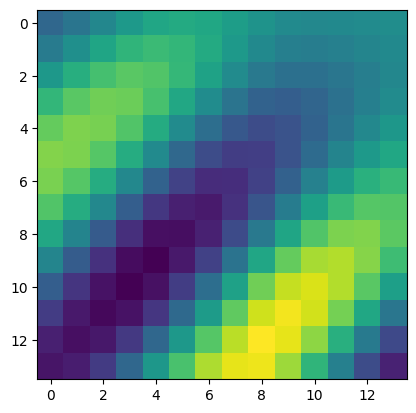

In [ ]:
# convolve the input image with the kernel and get co - efficients
# we will use only the real part and throw away the imaginary
# part of the co-efficients

image = x_train[0]. reshape ((14 ,14))
coeff_real, _ = gabor (image, frequency =freq, theta =theta, bandwidth = bandwidth )
plt. figure (1); plt.clf (); plt. imshow (coeff_real)

#### Problem 1.j

In [ ]:
theta = np.arange (0, np.pi, np.pi/4)
frequency = np.arange (0.05, 0.5, 0.15)
bandwidth = np.arange (0.3,1,0.3)

In [ ]:
theta

array([0.        , 0.78539816, 1.57079633, 2.35619449])

In [ ]:
frequency

array([0.05, 0.2 , 0.35])

#### Filter bank, parameter defined as above

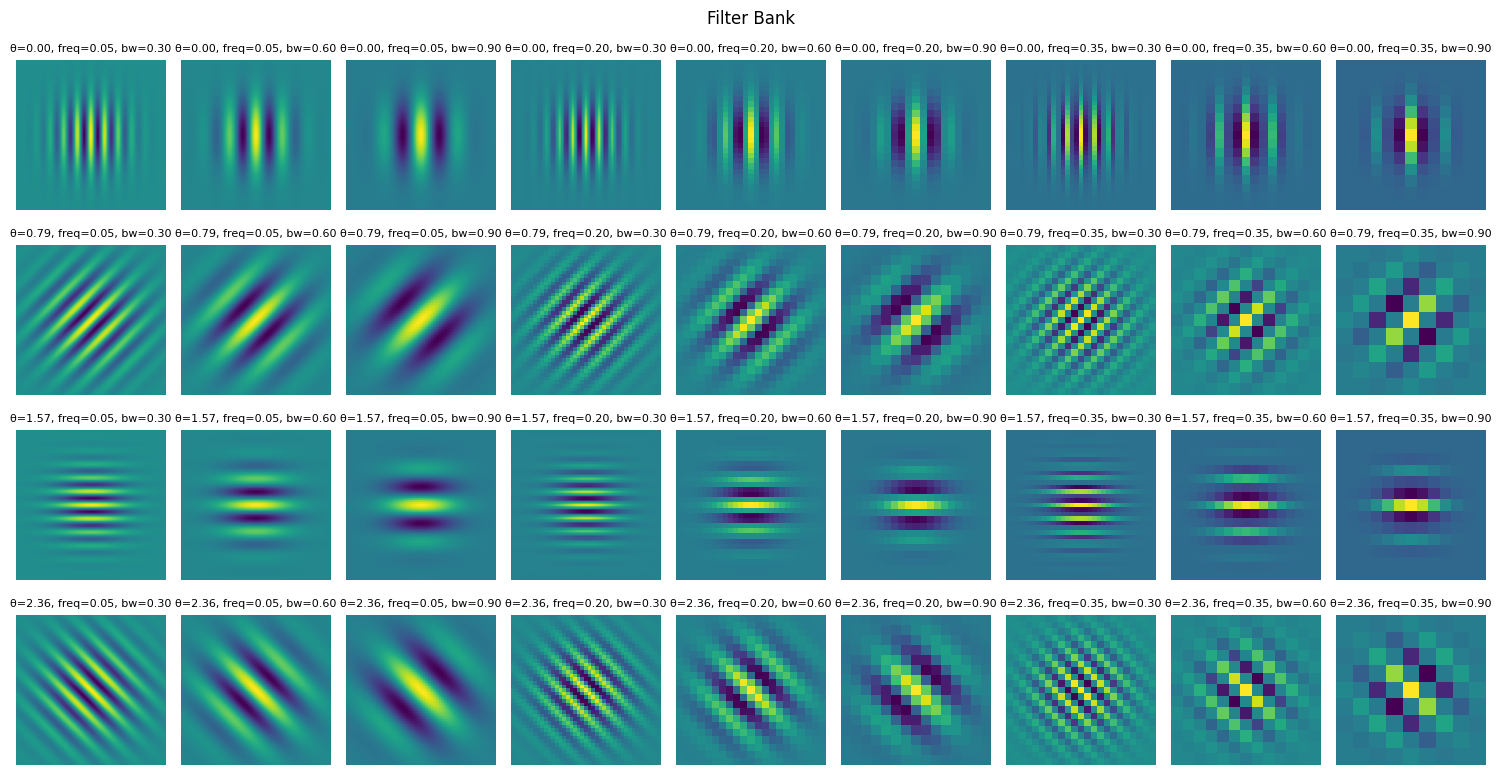

In [ ]:
fig, axes = plt.subplots(len(theta), len(frequency) * len(bandwidth), figsize=(15, 8))
fig.suptitle("Filter Bank", fontsize=12)

for row, t in enumerate(theta):
    col = 0
    for freq in frequency:
        for bw in bandwidth:
            gk = gabor_kernel(frequency=freq, theta=t, bandwidth=bw)

            ax = axes[row, col] # locate subplot

            # for each plot
            ax.imshow(gk.real) # Display the real part of the Gabor kernel
            ax.set_title(f"θ={t:.2f}, freq={freq:.2f}, bw={bw:.2f}", fontsize=8)
            ax.axis('off') # hide for next loop

            col += 1

plt.tight_layout()

#### Alert: computationally intensive.

In [ ]:
x_train_gabor = []

for i in range(0, len(x_train_small)):
  gabor_feature_i = []
  for t in theta:
      for freq in frequency:
          for bm in bandwidth:
            image = x_train_small[i].reshape((14 ,14))
            coeff_real , _ = gabor(image , frequency=freq , theta=t ,bandwidth=bm)
            gabor_feature_i.extend(coeff_real)
  x_train_gabor.append(np.array(gabor_feature_i).flatten())

In [ ]:
#def compute_gabor_features(image):
  #gabor_feature = []
  #for t in theta:
    #for freq in frequency:
     # for bm in bandwidth:
        #image = image.reshape((14 ,14))
        #coeff_real , _ = gabor(image , frequency=freq , theta=t ,bandwidth=bm)
        #gabor_feature.extend(coeff_real)
  #return np.array(gabor_feature).flatten()

  #x_train_gabor = np.apply_along_axis(compute_gabor_features, 1, x_train_small)

In [ ]:
x_val_gabor = []

for j in range(0, len(x_val_small)):
  gabor_feature_j = []
  for t in theta:
      for freq in frequency:
          for bm in bandwidth:
            image = x_val_small[j].reshape((14 ,14))
            coeff_real , _ = gabor(image , frequency=freq , theta=t ,bandwidth=bm)
            gabor_feature_j.extend(coeff_real)

  x_val_gabor.append(np.array(gabor_feature_j).flatten())

In [ ]:
scaler = StandardScaler()
x_train_gabor = scaler.fit_transform(x_train_gabor)
x_val_gabor = scaler.transform(x_val_gabor)
classifier = SVC(C=1.0, kernel='rbf', gamma='auto')
classifier.fit(x_train_gabor, y_train_small)

SVC(gamma='auto')

In [ ]:
y_pred_train_gabor = classifier.predict(x_train_gabor)
y_pred_val_gabor = classifier.predict(x_val_gabor)

In [ ]:
#len(y_pred_val_gabor)

1000

In [ ]:
train_error_gabor = 1 - accuracy_score(y_train_small, y_pred_train_gabor)
val_error_gabor = 1 - accuracy_score(y_val_small, y_pred_val_gabor)

print(f'Train Error: {train_error_gabor:.4f}')
print(f'Validation Error: {val_error_gabor:.4f}')

0.11499999999999999

# Standardize and PCA features

In [ ]:
scaler = StandardScaler()
scaler.fit(x_small_train_gabor)
x_small_gabor_train = scaler.transform(x_small_train_gabor)
x_small_gabor_val = scaler.transform(x_small_train_gabor)

#x_gabor_val[np.isnan(x_gabor_val)] = 0

In [ ]:
explained_variance = 0.98
pca = PCA(explained_variance)
pca.fit(x_small_gabor_train)
x_small_gabor_train_pca = pca.transform(x_small_gabor_train)
x_small_gabor_val_pca = pca.transform(x_small_gabor_val)
x_small_gabor_val_pca.shape

#### The following SVM occured from a GridSearch.
#### Best SVM classifier: Validation Accuracy > 93%

In [ ]:
classifier = svm.SVC(C=1.0, kernel='poly', gamma='auto', cache_size=1000, verbose=True)
classifier.fit(x_small_gabor_train,small_ny_train)
y_pred = classifier.predict(x_small_gabor_val)
print(y_pred)
print("Classifier Accuracy:", classifier.score(x_small_gabor_val, small_ny_val))